In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
#%matplotlib qt
%matplotlib inline


## UNDISTORT FUNCTION

In [2]:
def undistort(img):
    dist_pickle = pickle.load( open( "../calibration_coefficients/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undst)
    ax2.set_title('Undistorted Image', fontsize=30)
   

    return undst


## THRESHOLDED BINARIES  ** check color binary or s_binary to be returned

In [3]:
def to_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255  #seting red channel to zero
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(combined_binary,cmap='gray')
    ax1.set_title('Binary Image', fontsize=30)
    ax2.imshow(color_binary)
    ax2.set_title('Thresholded Color map Image', fontsize=30)
    return combined_binary

## PERSPECTIVE TRANSFORMATION/ UNWARP

In [4]:
def warp(binary):
    img_size = (binary.shape[1], binary.shape[0])
    offset = 100 # offset for dst points
    src = np.float32([[525.744,499.092],[762.396,499.092],[1046.65,682.505],[261.147,682.505]])
    dst = np.float32([[2*offset, offset], [img_size[0]-2*offset, offset], 
                                     [img_size[0]-2*offset, img_size[1]], 
                                     [2*offset, img_size[1]]]) #2*offset= horizantal clearance on either sides
    ##        1               2
    ##
    ##
    ##        4               3  ## represent order of coordinates in the arguments
    
    
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(binary, M, img_size)
    plt.figure()
    plt.imshow(warped,cmap='gray')
    
    return warped, M


## HISTOGRAM

In [5]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    plt.plot(histogram,'r', linewidth=3.5)
    plt.title("Warped with histogram", fontsize=30)
    return histogram

## SLIDING WINDOW

In [6]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        #Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    print("Leftx,lefty:",leftx.shape,lefty.shape)

    return leftx, lefty, rightx, righty, out_img



In [10]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #print(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension        
    
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.figure()

    ## from function search_around_poly
    ##https://classroom.udacity.com/nanodegrees/nd013/parts/168c60f1-cc92-450a-a91b-e427c326e6a7/modules/95d62426-4da9-49a6-9195-603e0f81d3f1/lessons/626f183c-593e-41d7-a828-eda3c6122573/concepts/474a329a-78d0-4a33-833a-34d02a35fc13
    
    window_img = np.zeros_like(out_img)
    margin=100
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    #print('####',left_line_pts)
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)


    plt.title("Lanes Detected using Sliding Window", fontsize=30)
    plt.imshow(result)
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    
    return out_img,result,ploty,left_fit,right_fit




In [11]:
def measure_curvature_pixels(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension        
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad




# PIPELINE FOR IMAGES ** change from single image to all images

## READ AND CLEAN AN IMAGE

Leftx,lefty: (31370,) (31370,)


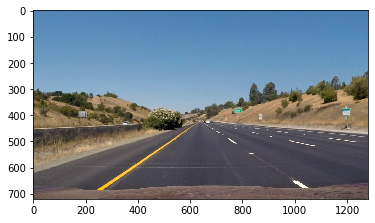

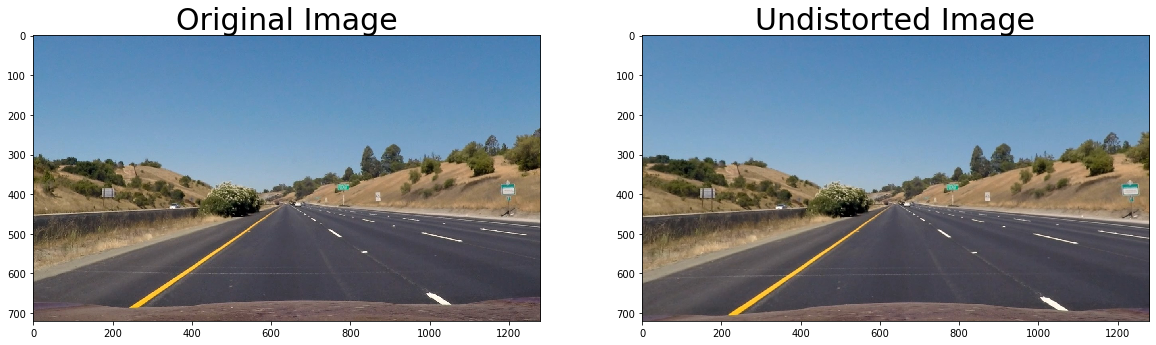

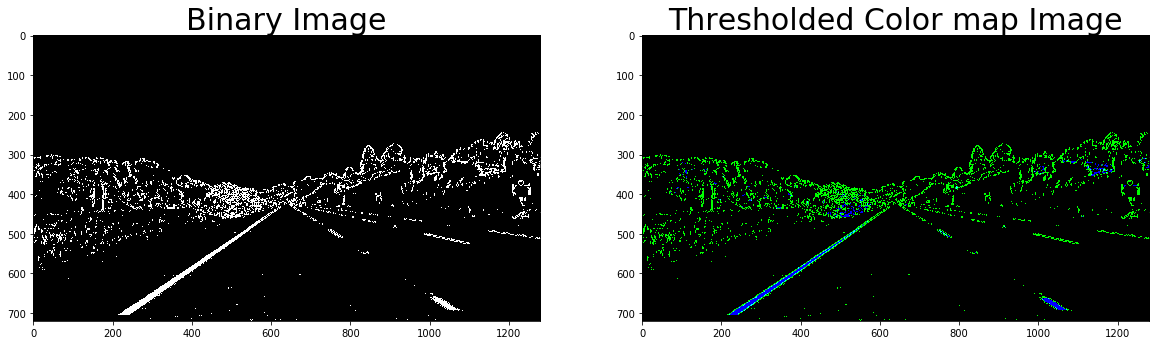

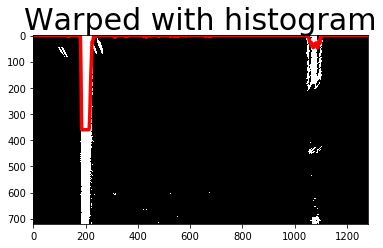

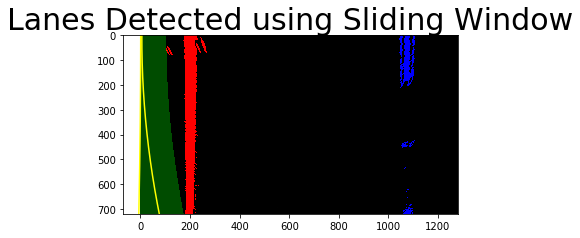

In [12]:
import glob
images = glob.glob("../test_images/single_image/st*.jpg")


import matplotlib.image as mpimg
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    plt.imshow(img)
    undst=undistort(img)
    binary=to_binary(undst)
    binary_warped, M=warp(binary)
    out_img,result,ploty,left_fit,right_fit = fit_polynomial(binary_warped)
    left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)
    
    
 

In [13]:
# Calculate the radius of curvature in pixels for both lane lines


print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

34350.917034464495 3554.938061445138
